In [101]:
import time
import optuna
import warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
train = pd.read_csv('./train.csv')
train = train[[i for i in train.columns if "Unnamed" not in i]]
test = pd.read_csv('./test.csv')
test = test[[i for i in test.columns if "Unnamed" not in i]]

## 資料前處理

In [102]:
# 處理訓練集
print(train.shape)
print(test.shape)

(103904, 24)
(25976, 24)


In [103]:
# 確定id不重複
print(len(np.unique(train.id)))
print(len(np.unique(test.id)))
# 移除id欄位
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

103904
25976


In [104]:
# 類別不平衡
print("Training set: \n",train["satisfaction"].value_counts(),"\n")
print("Testing set: \n",train["satisfaction"].value_counts(),"\n")

Training set: 
 neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64 

Testing set: 
 neutral or dissatisfied    58879
satisfied                  45025
Name: satisfaction, dtype: int64 



In [105]:
#觀察遺失值
train.isnull().sum()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64

In [106]:
test.isnull().sum()

Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64

In [107]:
# dropna()
# train = train.dropna()
# test = test.dropna()
# print(train.shape)
# print(test.shape)

In [108]:
# 用平均值填補Arrival Delay in Minutes
train["Arrival Delay in Minutes"]=train["Arrival Delay in Minutes"].fillna(np.mean(train["Arrival Delay in Minutes"]))
test["Arrival Delay in Minutes"]=test["Arrival Delay in Minutes"].fillna(np.mean(test["Arrival Delay in Minutes"]))

In [109]:
# 再檢查一次有無遺失值
print(len(train[train["Arrival Delay in Minutes"].isnull()]))
print(len(test[test["Arrival Delay in Minutes"].isnull()]))

0
0


In [110]:
# # EDA
# def bar_plot(variable):
    
#     var=train[variable]
#     var_Value=var.value_counts()
    
#     #visualize
#     plt.figure(figsize=(9,3))
#     plt.bar(var_Value.index,var_Value.values)
    
#     plt.xlabel("Passengers Score")
#     plt.ylabel("Frequency")
#     plt.title(variable)
#     plt.show()
#     print("{}: \n {}".format(variable,var_Value))
# #
# category1=["Inflight wifi service", "Departure/Arrival time convenient", "Ease of Online booking", "Gate location", "Food and drink", "Online boarding", "Seat comfort", "Inflight entertainment", "On-board service", "Leg room service", "Baggage handling", "Checkin service", "Inflight service", "Cleanliness",]
# for c in category1:
#     bar_plot(c)
# #
# category2=["Gender", "Customer Type", "Type of Travel", "Class","satisfaction"]
# for c in category2:
#     print("{} \n".format(train[c].value_counts()))
# # satisfaction vs.Gender & Customer_Type
# with sns.axes_style(style='ticks'):
#     g = sns.catplot("satisfaction", col="Gender", col_wrap=2, data=train, kind="count", height=2.5, aspect=1.0)  
#     g = sns.catplot("satisfaction", col="Customer Type", col_wrap=2, data=train, kind="count", height=2.5, aspect=1.0)
# # Age vs Passenger Satisfaction
# with sns.axes_style('white'):
#     g = sns.catplot("Age", data=train, aspect=3.0, kind='count', hue='satisfaction', order=range(5, 80))
#     g.set_ylabels('Age vs Passenger Satisfaction')
# #
# with sns.axes_style('white'):
#     g = sns.catplot(x="Flight Distance", y="Type of Travel", hue="satisfaction", col="Class", data=train, kind="bar", height=4.5, aspect=.8)
# #
# with sns.axes_style('white'):
#     g = sns.catplot(x="Departure/Arrival time convenient", y="Online boarding", hue="satisfaction", col="Class", data=train, kind="bar", height=4.5, aspect=.8)
# #
# with sns.axes_style('white'):
#     g = sns.catplot(x="Class", y="Departure Delay in Minutes", hue="satisfaction", col="Type of Travel", data=train, kind="bar", height=4.5, aspect=.8)
#     g = sns.catplot(x="Class", y="Arrival Delay in Minutes", hue="satisfaction", col="Type of Travel", data=train, kind="bar", height=4.5, aspect=.8)

In [111]:
# one hot encoding
train['Gender'].unique()
class_mapping = { 'Male':1, 'Female':0}
train['Gender'] = train['Gender'].map(class_mapping)
test['Gender'] = test['Gender'].map(class_mapping)
# 
train['Customer Type'].unique()
class_mapping = { 'Loyal Customer':1, 'disloyal Customer':0}
train['Customer Type'] = train['Customer Type'].map(class_mapping)
test['Customer Type'] = test['Customer Type'].map(class_mapping)
#
train['Type of Travel'].unique()
class_mapping = { 'Personal Travel':0, 'Business travel':1}
train['Type of Travel'] = train['Type of Travel'].map(class_mapping)
test['Type of Travel'] = test['Type of Travel'].map(class_mapping)
# 
train['satisfaction'].unique()
class_mapping = { 'neutral or dissatisfied':0, 'satisfied':1}
train['satisfaction'] = train['satisfaction'].map(class_mapping)
test['satisfaction'] = test['satisfaction'].map(class_mapping)
# label encoding
train['Class'].unique()
class_mapping = { 'Eco Plus':2, 'Business':3,'Eco':1}
train['Class'] = train['Class'].map(class_mapping)
test['Class'] = test['Class'].map(class_mapping)

<AxesSubplot:>

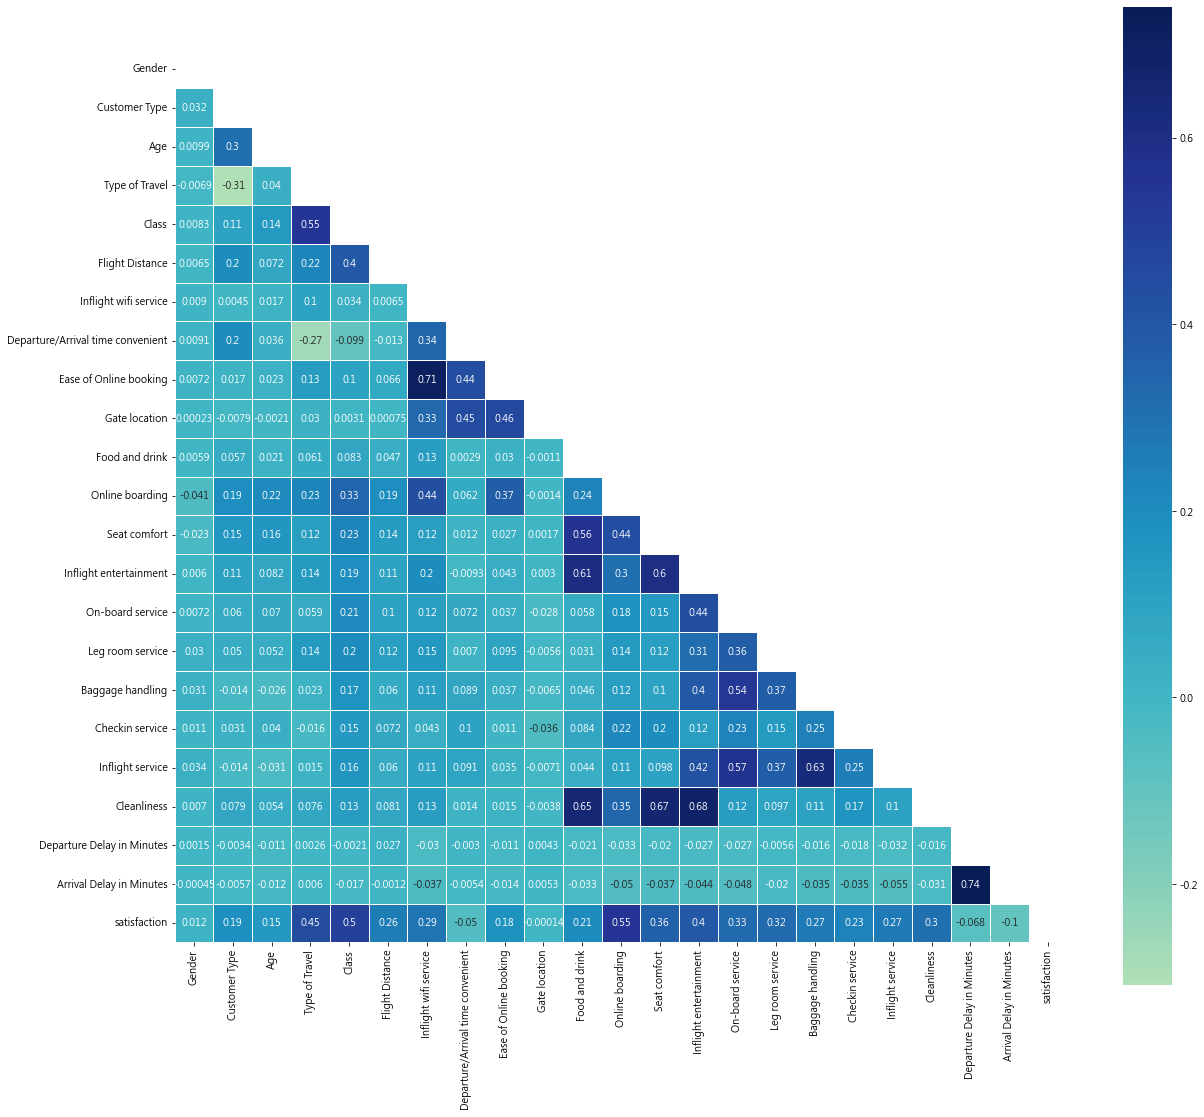

In [112]:
#熱力圖
corr = train.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)



In [113]:
# def checkVIF(df):
#     from statsmodels.stats.outliers_influence import variance_inflation_factor
#     df['c'] = 1
#     name = df.columns
#     x = np.matrix(df)
#     VIF_list = [variance_inflation_factor(x,i) for i in range(x.shape[1])]
#     VIF = pd.DataFrame({'feature':name,"VIF":VIF_list})
#     VIF = VIF.sort_values("VIF",ascending=False).reset_index(drop=True)
#     VIF = VIF.drop([0]).reset_index(drop=True)
#     return VIF
# vif_df = checkVIF(train)
# 拿掉Arrival Delay in Minures 跟 Ease of Online booking看看
# vif_df

由熱力圖可以發現，變數"Ease of Online booking" & "Inflight wifi service" 相關性 為0.71；"Departure Delay in Minutes"& "Arrival Delay in Minutes" 相關性0.74，兩組係數大於0.7存在共線性問題，必須擇一剔除，同時衡量顧客滿意度的變數眾多，總共有22個，下一階段先進行重要變數篩選，再將挑選後的變數進行模型訓練

In [114]:
#建立衡量function
def model_evaluation(model, X_train, y_train, X_test, y_test):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    print("------------------Training Result--------------------")
    print("Training_Accuracy = {}".format(accuracy_score(y_train, train_pred)))
    print("Training_Precision = {}".format(precision_score(y_train, train_pred)))
    print("Training_Recall = {}".format(recall_score(y_train, train_pred)))
    print("Training_F1-score = {}".format(f1_score(y_train, train_pred)))
    plot_confusion_matrix(model, X_train, y_train,cmap=plt.cm.pink, normalize="all")
    print("------------------Testing Result--------------------")
    print("Testing_Accuracy = {}".format(accuracy_score(y_test, test_pred)))
    print("Testing_Precision = {}".format(precision_score(y_test, test_pred)))
    print("Testing_Recall = {}".format(recall_score(y_test, test_pred)))
    print("Testing_F1-score = {}".format(f1_score(y_test, test_pred)))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.pink, normalize = "all")                
    
    return model

In [115]:
X_train = train.drop(columns="satisfaction")
y_train =  train.satisfaction
X_test = test.drop(columns = "satisfaction")
y_test  = test.satisfaction

## 模型參數與調參

經過了0.4195680618286133 秒
------------------Training Result--------------------
Training_Accuracy = 0.9661321989528796
Training_Precision = 0.9774536419270234
Training_Recall = 0.9436091060521933
Training_F1-score = 0.9602332440587179
------------------Testing Result--------------------
Testing_Accuracy = 0.964197720973206
Testing_Precision = 0.974277692238022
Testing_Recall = 0.9433482416907831
Testing_F1-score = 0.9585635359116023


LGBMClassifier(random_state=530)

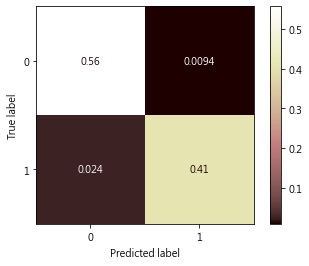

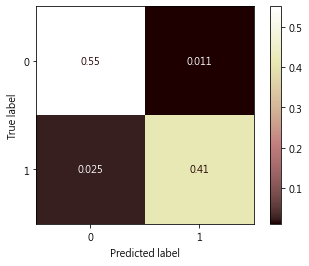

In [116]:
##########
# 調參前 #
##########
start = time.time()
clf = lgb.LGBMClassifier(random_state = 530)
clf.fit(X_train, y_train)
end = time.time()
print("經過了{}".format(end-start),"秒")
model_evaluation(clf,X_train, y_train, X_test, y_test)

In [117]:
##########
# Optuna #
##########
def objective(trial):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_test, label=y_test)

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "max_depth":-1,
        "seed":530,
        "learning_rate":trial.suggest_float("learning_rate",0.01,0.5),
        "n_estimators": trial.suggest_int("n_estimator", 100,500),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 2, 30),
    }

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "auc")
    gbm = lgb.train(param, dtrain, valid_sets=[dvalid], callbacks=[pruning_callback])

    preds = gbm.predict(X_test)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_test, pred_labels)
    return accuracy

study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction="maximize" )
study.optimize(objective, n_trials=100)
print("Number of finished trials: {}".format(len(study.trials)))
trial = study.best_trial
# print("Best trial: {}".format(study.best_trial))
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}= {}".format(key, value))

經過了2.1263701915740967 秒
------------------Training Result--------------------
Training_Accuracy = 0.9905970896211888
Training_Precision = 0.9957234176645359
Training_Recall = 0.9825208217656858
Training_F1-score = 0.9890780633405253
------------------Testing Result--------------------
Testing_Accuracy = 0.9662765629812134
Testing_Precision = 0.9762055550529268
Testing_Recall = 0.946242216960449
Testing_F1-score = 0.9609903811898824


LGBMClassifier(colsample_bytree=0.7531772141117373,
               learning_rate=0.07235046840654702, min_child_samples=18,
               n_estimators=389, num_leaves=86, random_state=530,
               reg_alpha=0.22442622540074775, reg_lambda=0.4152448093239704,
               subsample=0.645426949332951)

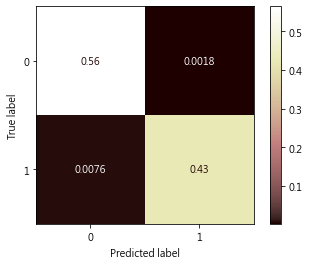

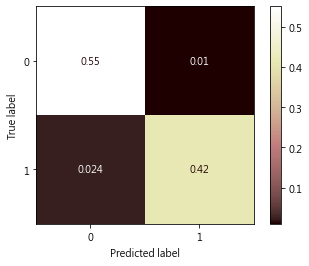

In [118]:
start = time.time()
clf_optuna = lgb.LGBMClassifier(learning_rate=0.07235046840654702,n_estimators=389,reg_alpha=0.22442622540074775,reg_lambda=0.4152448093239704,
num_leaves=86,colsample_bytree=0.7531772141117373,subsample= 0.645426949332951,min_child_samples= 18,random_state=530)
clf_optuna.fit(X_train, y_train)
end = time.time()
print("經過了{}".format(end-start),"秒")
model_evaluation(clf_optuna,X_train, y_train, X_test, y_test)

In [119]:
################
# GridSearchCV #
################
start = time.time()
parameters = {
    'max_depth': [6,8,-1],
    'num_leaves': [20,31,40],
    "n_estimators":[50,100,200],
    "min_child_samples":[10,20,30],
    "learning_rate":[0.3,0.1,0.01],
    "subsample":[0.8,1],
    "colsample_bytree":[0.8,1],
    "reg_alpha":[0,0.1],
    "min_split_gain":[0,0.1]
}
clf = lgb.LGBMClassifier(random_state = 530)
gsearch = GridSearchCV(clf, param_grid=parameters, scoring='roc_auc',cv=3,verbose=3)
gsearch.fit(X_train, y_train)
end = time.time()
print("經過了{}".format(end-start),"秒")
print('参数的最佳取值:{0}'.format(gsearch.best_params_))
print('最佳模型得分:{0}'.format(gsearch.best_score_))
# 花了88分鐘
param_result = {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 
'min_split_gain': 0, 'n_estimators': 200, 'num_leaves': 40, 'reg_alpha': 0, 'subsample': 0.8}

經過了0.711113691329956 秒
------------------Training Result--------------------
Training_Accuracy = 0.9746496766245766
Training_Precision = 0.9844132099188664
Training_Recall = 0.9566463076068851
Training_F1-score = 0.9703311556656904
------------------Testing Result--------------------
Testing_Accuracy = 0.9656606097936556
Testing_Precision = 0.9756539053307992
Testing_Recall = 0.94536525475752
Testing_F1-score = 0.9602707999287368


LGBMClassifier(colsample_bytree=0.8, n_estimators=200, num_leaves=40,
               random_state=530, reg_alpha=0, subsample=0.8)

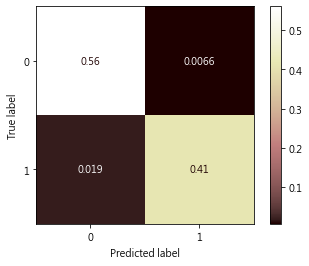

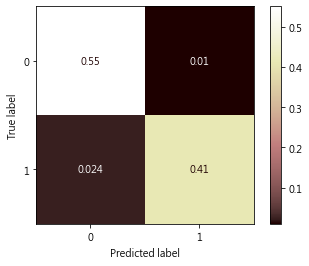

In [120]:
# grid_search_result
start = time.time()
clf_grid = lgb.LGBMClassifier(learning_rate=0.1,n_estimators=200,reg_alpha=0,num_leaves=40,colsample_bytree=0.8,subsample= 0.8,min_child_samples= 20,random_state=530)
clf_grid.fit(X_train, y_train)
end = time.time()
print("經過了{}".format(end-start),"秒")
model_evaluation(clf_grid,X_train, y_train, X_test, y_test)

## 模型比較

經過了10.618349552154541 秒
------------------Training Result--------------------
Training_Accuracy = 1.0
Training_Precision = 1.0
Training_Recall = 1.0
Training_F1-score = 1.0
------------------Testing Result--------------------
Testing_Accuracy = 0.9635817677856483
Testing_Precision = 0.9732959174436498
Testing_Recall = 0.9429097605893186
Testing_F1-score = 0.9578619153674833


RandomForestClassifier(random_state=530)

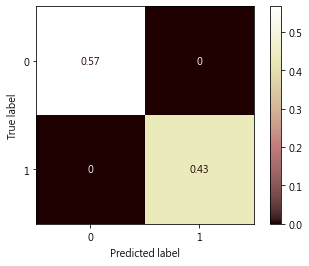

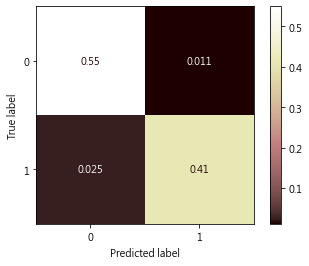

In [121]:
################
# RandomForest #
################
from sklearn.ensemble import RandomForestClassifier
start = time.time()
rf=RandomForestClassifier(random_state=530)
rf.fit(X_train, y_train)
end = time.time()
print("經過了{}".format(end-start),"秒")
model_evaluation(rf,X_train, y_train, X_test, y_test)

經過了0.6901223659515381 秒
------------------Training Result--------------------
Training_Accuracy = 0.7736660763781953
Training_Precision = 0.719496264848757
Training_Recall = 0.7829205996668518
Training_F1-score = 0.7498697071868453
------------------Testing Result--------------------
Testing_Accuracy = 0.7771789344009855
Testing_Precision = 0.7262835496090917
Testing_Recall = 0.7902306410593704
Testing_F1-score = 0.7569088618227635


LogisticRegression(random_state=530)

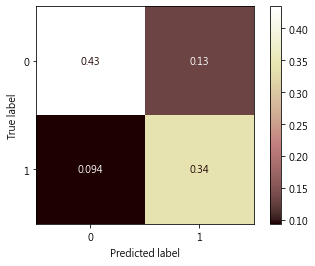

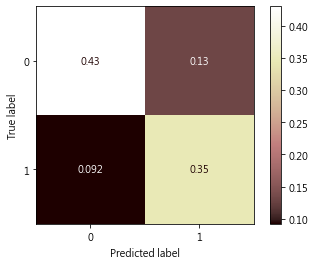

In [122]:
#######################
# Logistic regression #
#######################
start = time.time()
lr=LogisticRegression(random_state=530)
lr.fit(X_train, y_train)
end = time.time()
print("經過了{}".format(end-start),"秒")
model_evaluation(lr,X_train, y_train, X_test, y_test)

經過了0.6279358863830566 秒
------------------Training Result--------------------
Training_Accuracy = 1.0
Training_Precision = 1.0
Training_Recall = 1.0
Training_F1-score = 1.0
------------------Testing Result--------------------
Testing_Accuracy = 0.9478749615029258
Testing_Precision = 0.9391661568044751
Testing_Recall = 0.9422958870472683
Testing_F1-score = 0.9407284188408335


DecisionTreeClassifier()

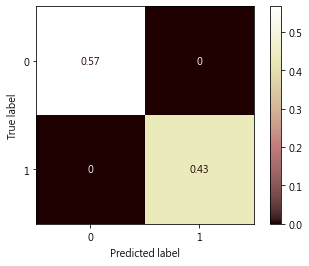

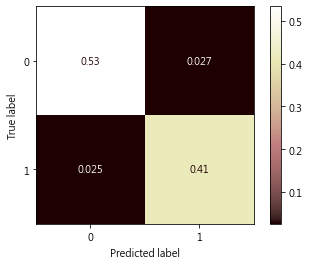

In [123]:
#################
# Decision Tree #
#################
start = time.time()
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
end = time.time()
print("經過了{}".format(end-start),"秒")
model_evaluation(dt,X_train, y_train, X_test, y_test)

## 變數重要性

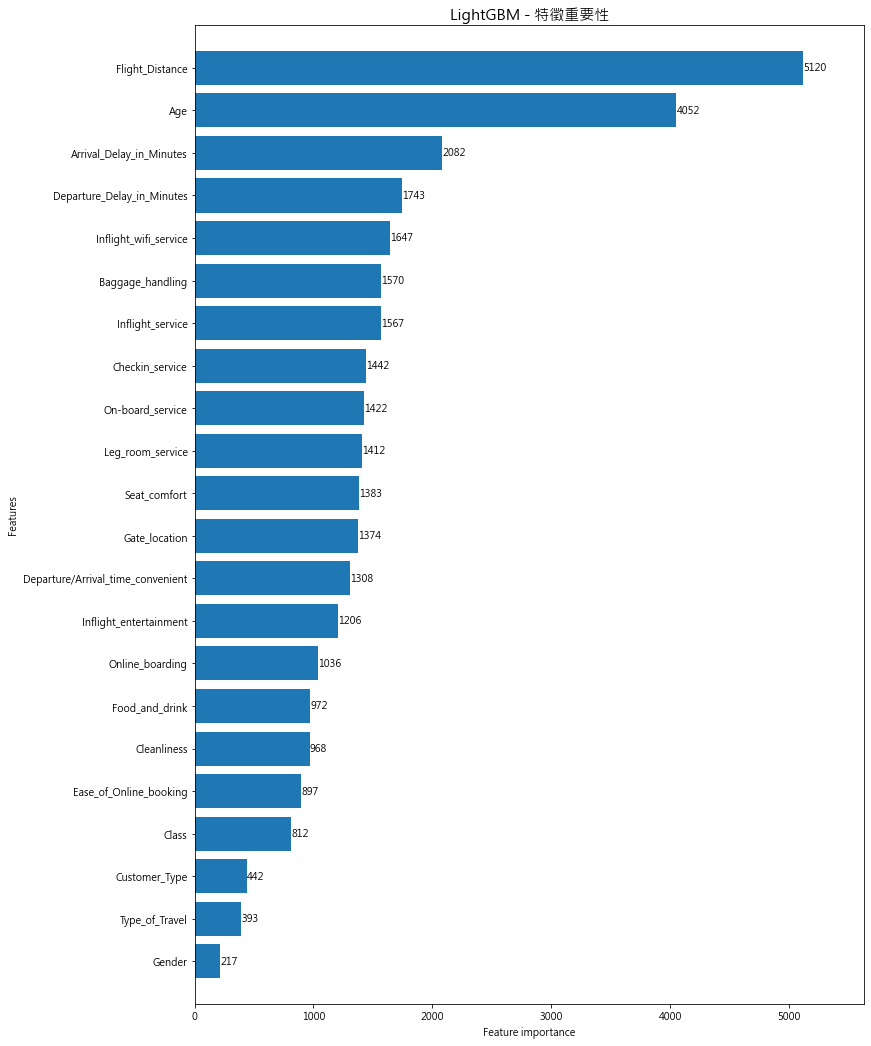

In [124]:
# LGBM
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(clf_optuna, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - 特徵重要性", fontsize=15)
plt.savefig("LGBM特徵重要性.png")

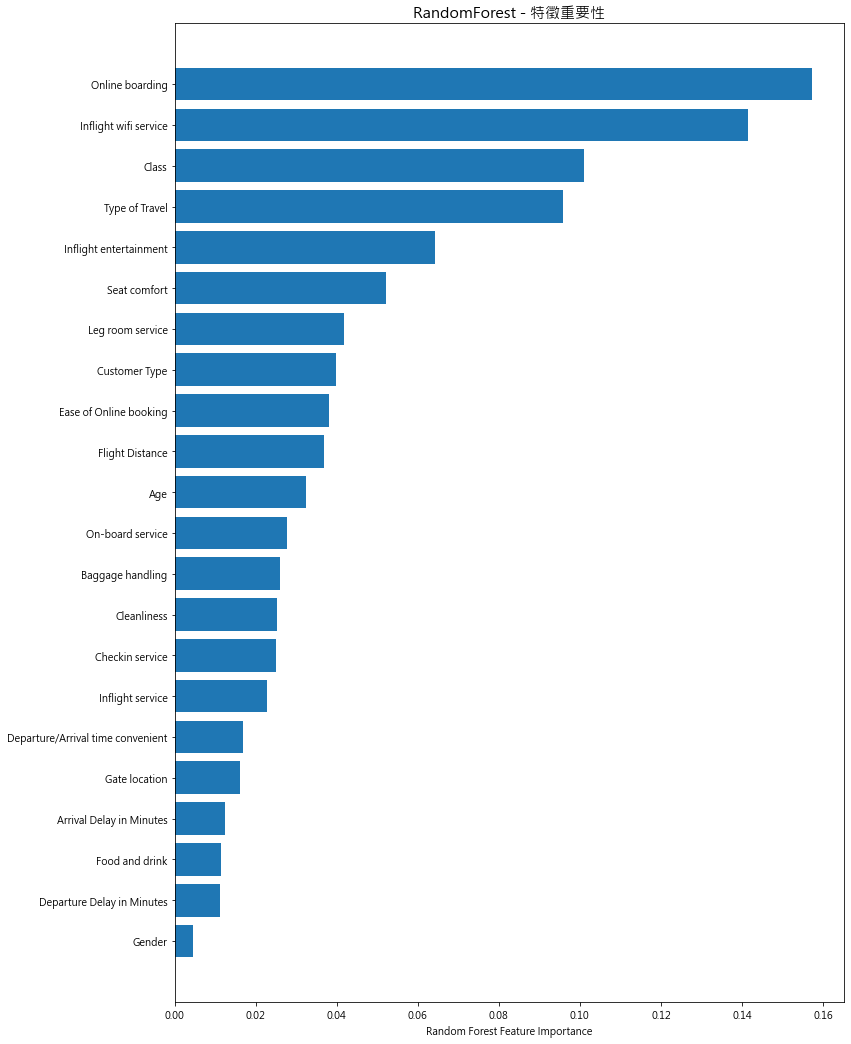

In [125]:
fig, ax = plt.subplots(figsize=(12,18))
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.title("RandomForest - 特徵重要性", fontsize=15)
plt.savefig("RandomForest特徵重要性.png")